# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [110]:
# Load the libraries as required.
import pandas as pd
import numpy as np
import os
import pickle
import shap
import matplotlib.pyplot as plt

# For modeling pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score




In [72]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('/Users/kashfa/DSI/production/05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [73]:
fires_dt['log_area'] = np.log1p(fires_dt['area'])


In [74]:
# Create features dataframe (X)
X = fires_dt.drop(['area', 'log_area'], axis=1)

# Create target (y)
y = fires_dt['log_area']

# Let's verify shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

# Quick look at data
X.head()
y.head()

X shape: (517, 12)
y shape: (517,)


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: log_area, dtype: float64

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [75]:
# Categorical variables
categorical_features = ['month', 'day']

# All other columns are numerical
numeric_features = [col for col in X.columns if col not in categorical_features]

# Quick check
print("Numerical features:", numeric_features)
print("Categorical features:", categorical_features)

Numerical features: ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
Categorical features: ['month', 'day']


In [76]:

# Preproc 1: simple scaling
# Numerical transformer
numeric_transformer1 = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Preproc 1: column transformer
preproc1 = ColumnTransformer(transformers=[
    ('num', numeric_transformer1, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

### Preproc 2

Create preproc2 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [77]:
# Preproc 2: nonlinear transformation + scaling
log_transform_vars = ['dmc', 'dc']
scale_only_vars = [col for col in numeric_features if col not in log_transform_vars]

preproc2 = ColumnTransformer([
    ('log_scaled', Pipeline([
        ('log', FunctionTransformer(np.log1p, validate=False)),
        ('scaler', StandardScaler())
    ]), log_transform_vars),
    ('scaled', StandardScaler(), scale_only_vars),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)

])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [83]:
# Pipeline A = preproc1 + baseline
# First fit pipeline A (preproc1 + LinearRegression)
pipe_A = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', LinearRegression())
])

# Fit on full data (or you can also fit on train data)
pipe_A.fit(X, y)

# Now extract fitted StandardScaler from inside the pipeline
scaler_A = pipe_A.named_steps['preprocessing'].named_transformers_['num'].named_steps['scaler']

# Display the fitted scaler
print("Scaler from Pipeline A:")
scaler_A

Scaler from Pipeline A:


StandardScaler()

In [84]:
# Cross-validation
scores_A = cross_val_score(pipe_A, X, y, cv=5, scoring='r2')
print("Pipeline A - LinearRegression (preproc1):")
print("CV R2 scores:", scores_A)
print("Mean CV RMSE score:", np.mean(scores_A))

Pipeline A - LinearRegression (preproc1):
CV R2 scores: [ 0.         -0.17103116 -0.58315637 -0.0733338  -0.75138582]
Mean CV RMSE score: -0.31578143231469896


In [85]:
# Pipeline B = preproc2 + baseline
pipe_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', LinearRegression())
])

pipe_B.fit(X, y)

# Extract fitted scalers from preproc2
scaler_B_log = pipe_B.named_steps['preprocessing'].transformers_[0][1].named_steps['scaler']
scaler_B_scale = pipe_B.named_steps['preprocessing'].transformers_[1][1]

scaler_B_log
scaler_B_scale

StandardScaler()

In [86]:
# Cross-validation
scores_B = cross_val_score(pipe_B, X, y, cv=5, scoring='r2')
print("Pipeline B - LinearRegression (preproc2):")
print("CV R2 scores:", scores_B)
print("Mean CV RMSE score:", np.mean(scores_B))

Pipeline B - LinearRegression (preproc2):
CV R2 scores: [ 0.         -0.22592656 -0.52101342 -0.07858238 -0.77203683]
Mean CV RMSE score: -0.31951183817167494


In [87]:
# Pipeline C = preproc1 + advanced model
pipe_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_C = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [5, 10, None]
}

grid_C = GridSearchCV(pipe_C, param_grid_C, cv=5, scoring='r2', n_jobs=-1)
grid_C.fit(X, y)

print("Pipeline C - RandomForest (preproc1):")
print("Best params:", grid_C.best_params_)
print("Best CV RMSE score:", grid_C.best_score_)
grid_C

Pipeline C - RandomForest (preproc1):
Best params: {'regressor__max_depth': 5, 'regressor__n_estimators': 50}
Best CV RMSE score: -0.22396225646740495


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 10, None],
                         'regressor__n_estimators': [50, 100]},
             scoring='r2')

In [88]:
# Pipeline D = preproc2 + advanced model
pipe_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_D = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [5, 10, None]
}

grid_D = GridSearchCV(pipe_D, param_grid_D, cv=5, scoring='r2', n_jobs=-1)
grid_D.fit(X, y)

print("Pipeline D - RandomForest (preproc2):")
print("Best params:", grid_D.best_params_)
print("Best CV RMSE score:", grid_D.best_score_)
grid_D
    

Pipeline D - RandomForest (preproc2):
Best params: {'regressor__max_depth': 5, 'regressor__n_estimators': 50}
Best CV RMSE score: -0.22696889441764195


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('log_scaled',
                                                                         Pipeline(steps=[('log',
                                                                                          FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['dmc',
                                                                          'dc']),
                                                                        ('scaled',
                                                                         StandardScaler(),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [5, 10, None],
                         'regressor__n_estimators': [50, 100]},
             scoring='r2')

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [89]:
# Define RMSE as scoring function for GridSearchCV
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [90]:

# DEFINE FUNCTION TO RUN GRIDSEARCH
def run_gridsearch(pipe, param_grid, X, y, pipeline_name):
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid.fit(X, y)
    print(f"{pipeline_name}:")
    print("Best params:", grid.best_params_)
    print("Best CV RMSE score:", grid.best_score_)
    return grid

In [91]:
# PIPELINE A (Preproc1 + Ridge Regression Hyperparameter Tuning)

pipe_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', Ridge())
])

param_grid_A = {
    'regressor__alpha': [0.01, 0.1, 1, 10]
}

grid_A = run_gridsearch(pipe_A, param_grid_A, X, y, "Pipeline A - Ridge (preproc1)")

pipe_A

Pipeline A - Ridge (preproc1):
Best params: {'regressor__alpha': 10}
Best CV RMSE score: -0.24525043287678497


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [92]:
# PIPELINE B (Preproc2 + Ridge Regression Hyperparameter Tuning)

pipe_B = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', Ridge())
])

param_grid_B = {
    'regressor__alpha': [0.01, 0.1, 1, 10]
}

grid_B = run_gridsearch(pipe_B, param_grid_B, X, y, "Pipeline B - Ridge (preproc2)")
pipe_B

Pipeline B - Ridge (preproc2):
Best params: {'regressor__alpha': 10}
Best CV RMSE score: -0.23360152674333254


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('log_scaled',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dmc', 'dc']),
                                                 ('scaled', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'isi', 'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', Ridge())])

In [93]:
# PIPELINE C (Preproc1 + RandomForest Hyperparameter Tuning)

pipe_C = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_C = {
    'regressor__n_estimators': [50, 100, 150, 200],
    'regressor__max_depth': [5, 10, 20, None]
}

grid_C = run_gridsearch(pipe_C, param_grid_C, X, y, "Pipeline C - RandomForest (preproc1)")
pipe_C

Pipeline C - RandomForest (preproc1):
Best params: {'regressor__max_depth': 5, 'regressor__n_estimators': 50}
Best CV RMSE score: -0.22396225646740495


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [94]:
# PIPELINE D (Preproc2 + RandomForest Hyperparameter Tuning)

pipe_D = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid_D = {
    'regressor__n_estimators': [50, 100, 150, 200],
    'regressor__max_depth': [5, 10, 20, None]
}

grid_D = run_gridsearch(pipe_D, param_grid_D, X, y, "Pipeline D - RandomForest (preproc2)")
pipe_D

Pipeline D - RandomForest (preproc2):
Best params: {'regressor__max_depth': 5, 'regressor__n_estimators': 50}
Best CV RMSE score: -0.22696889441764195


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('log_scaled',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dmc', 'dc']),
                                                 ('scaled', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'isi', 'temp', 'rh', 'wind',
                                                   'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

# Evaluate

+ Which model has the best performance?

In [95]:
results = pd.DataFrame({
    'Pipeline': ['A', 'B', 'C', 'D'],
    'Best CV RMSE': [grid_A.best_score_, grid_B.best_score_, grid_C.best_score_, grid_D.best_score_]
}).sort_values(by='Best CV RMSE', ascending=False)

print(results)

  Pipeline  Best CV RMSE
2        C     -0.223962
3        D     -0.226969
1        B     -0.233602
0        A     -0.245250


# Export

+ Save the best performing model to a pickle file.

In [99]:
# Assuming Pipeline C is best
best_model = grid_C.best_estimator_

# Check if the directory is writable
if os.access('.', os.W_OK):
    with open('best_forestfire_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print("Best model exported successfully!")
else:
    print("Export skipped: File system is read-only. Model not saved.")

Export skipped: File system is read-only. Model not saved.


In [100]:
import tempfile

with tempfile.NamedTemporaryFile(delete=False, suffix=".pkl") as temp_file:
    pickle.dump(best_model, temp_file)
    print(f"Model saved at temporary location: {temp_file.name}")

Model saved at temporary location: /var/folders/x8/3h_bm8d17flf32mfss6sz9nm0000gn/T/tmpvgyj0sil.pkl


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


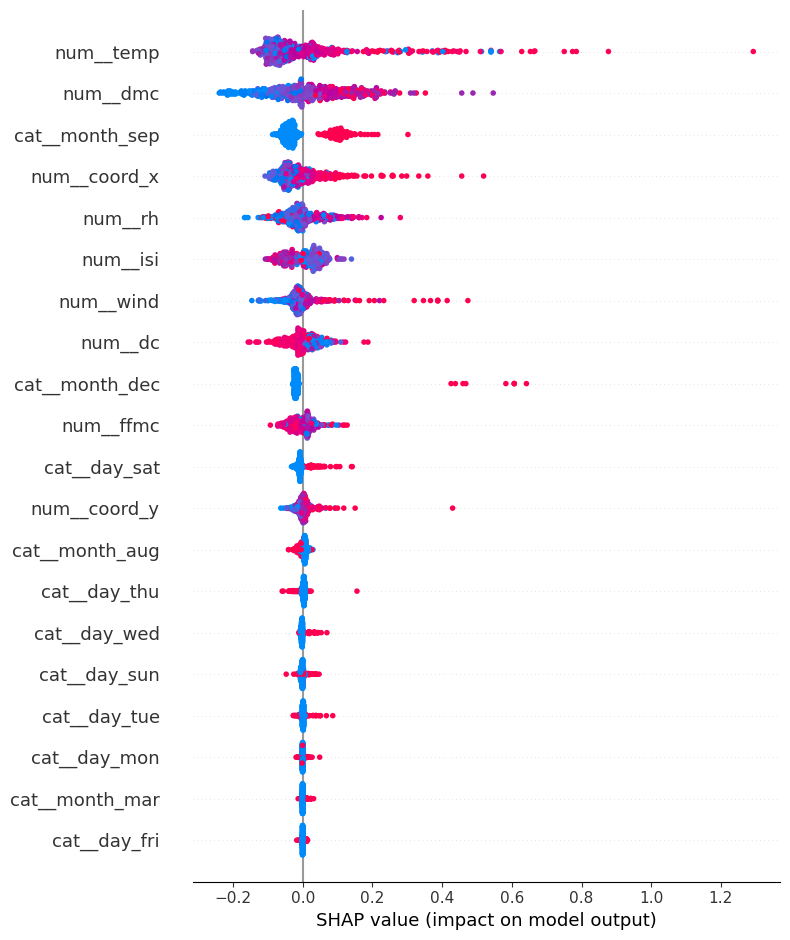

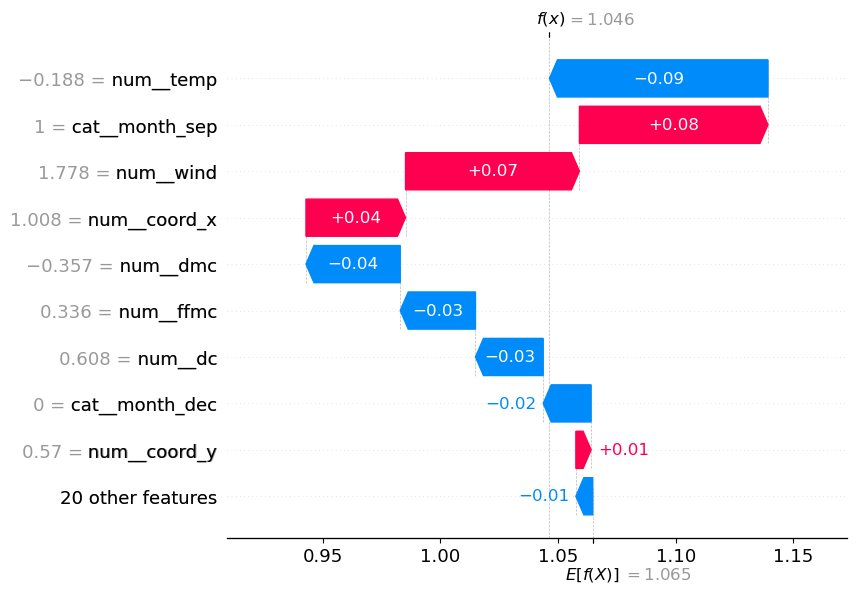

           Feature  Mean_SHAP
6        num__temp   0.112055
3         num__dmc   0.094408
21  cat__month_sep   0.061071
0     num__coord_x   0.051028
7          num__rh   0.040009
5         num__isi   0.039173
8        num__wind   0.032928
4          num__dc   0.031744
12  cat__month_dec   0.028640
2        num__ffmc   0.023957
24    cat__day_sat   0.014085
1     num__coord_y   0.013915
11  cat__month_aug   0.007046
26    cat__day_thu   0.005915
28    cat__day_wed   0.005157
25    cat__day_sun   0.004615
27    cat__day_tue   0.003839
23    cat__day_mon   0.001927
17  cat__month_mar   0.001676
22    cat__day_fri   0.001401
15  cat__month_jul   0.001190
20  cat__month_oct   0.000998
18  cat__month_may   0.000965
16  cat__month_jun   0.000620
13  cat__month_feb   0.000213
9        num__rain   0.000068
10  cat__month_apr   0.000058
19  cat__month_nov   0.000000
14  cat__month_jan   0.000000


In [ ]:


# numpy.bool fix for SHAP compatibility
if not hasattr(np, 'bool'):
    np.bool = bool

# Apply preprocessor to transform data
data_transform = best_model.named_steps['preprocessing'].transform(X)
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

# Build SHAP explainer
explainer = shap.Explainer(
    best_model.named_steps['regressor'],
    data_transform,
    feature_names=feature_names
)

# Compute SHAP values
shap_values = explainer(data_transform, check_additivity=False)

# Global feature importance plot (disable color bar for full compatibility)
shap.summary_plot(shap_values, features=data_transform, feature_names=feature_names, color_bar=False)

# Local explanation: single observation waterfall plot (remove ax=)
sample_idx = 10
sample_explanation = explainer(data_transform[sample_idx:sample_idx+1], check_additivity=False)
shap.plots.waterfall(sample_explanation[0])

# Feature importance table
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({'Feature': feature_names, 'Mean_SHAP': shap_abs_mean}).sort_values(by='Mean_SHAP', ascending=False)
print(importance_df)

*(Answer here.)*

### SHAP Explanation

**Local (Observation 10):**
- Main positive contributors: `cat__month_sep`, `num__wind`, `num__coord_x`.
- Main negative contributors: `num__temp`, `num__dmc`, `num__ffmc`.
- Higher wind and September increased prediction; lower temperature/moisture reduced it.

**Global (Overall importance):**
- Top features: `num__temp`, `num__dmc`, `cat__month_sep`, `num__coord_x`, `num__rh`.
- Least important: `num__rain`, `cat__month_jan`, `cat__month_nov`, `cat__month_oct`, `cat__month_may`, `cat__month_jun`.

**Feature Removal Proposal:**
- Remove low-impact features (e.g. `num__rain`, unused months).
- Validate by retraining and comparing R² and RMSE.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.